In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.signal as ss
from matplotlib import rc
from astropy.modeling.models import Gaussian2D
from photutils.isophote import EllipseGeometry
from photutils import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model
plt.rcParams.update({'font.size': 10})
plt.rc('font', family='serif')

In [2]:
D = np.load('npy/pulse_1005645324.fits.npy')

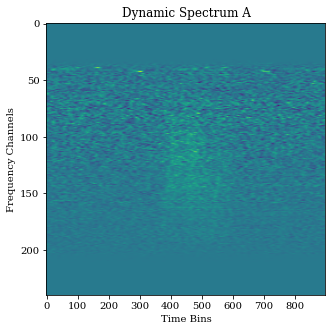

In [9]:
subfac = 16
sub = rb_sub = np.nanmean(D.reshape(-1, subfac, D.shape[1]), axis=1)
sav = ss.savgol_filter(sub, 49, 6)
fig = plt.figure(figsize = (5, 5))
plt.imshow(sav[:, 800:1700], aspect = 'auto', interpolation = None)
plt.ylabel('Frequency Channels')
plt.xlabel('Time Bins')
plt.title('Dynamic Spectrum A')
fig.savefig('D_dynspec.png')

[889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906
 907 908]


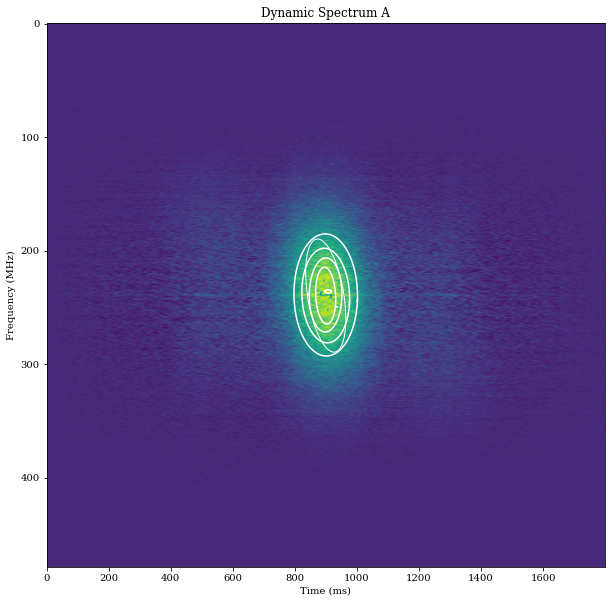

In [24]:
xhi = 1700
xlo = 800

sav_c = sav[:, xlo:xhi]

#Calculate 2D ACF
acf = ss.correlate(sav_c, sav_c)

print(np.arange(int((len(acf.sum(0)))/2 - 10), int(len(acf.sum(0))/2 + 10)))

#Mask acf to eliminate peakiness
#acf[len(acf.sum(1))//2 -1 : len(acf.sum(1))//2 +1, :] \
#    = np.ones(len(acf.sum(0)))*np.mean(acf[len(acf.sum(1))//2 +1:len(acf.sum(1))//2 +5, :])

#Cap acf values
cap = np.mean(acf[len(acf.sum(1))//2 +1:len(acf.sum(1))//2 +2, len(acf.sum(0))//2 +10:len(acf.sum(0))//2 +20])
acf[acf > cap] = cap/2


#Ellipse Parameters
sma = 70
eps = 0.4
pa = 0.5
#pa = 60 * np.pi/180

#Provide the initial Ellipse to be fitted
#Calculate Ellipse Geometry
geometry = EllipseGeometry(x0 = acf.shape[1]/2, \
            y0 = acf.shape[0]/2, sma = sma, eps = eps, pa = pa)
#Show Initial Guess Ellipsee
aper = EllipticalAperture((geometry.x0, geometry.y0), \
            geometry.sma, geometry.sma*(1-geometry.eps),geometry.pa)

#Plot Initial Guess Ellipse on ACF
fig = plt.figure(figsize = (10, 10))
plt.imshow(acf, aspect = 'auto')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum A')
aper.plot(color='white')
#fig.savefig('A.png')

#Fit Ellipse to 2D ACF
try:
    ellipse = Ellipse(acf, geometry)
    isolist = ellipse.fit_image()
    model_image = build_ellipse_model(acf.shape, isolist)
    residual = acf - model_image
    
    smas = np.linspace(10, 100, 5)
    for sma in smas:
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        plt.plot(x, y, color='white')
except OverflowError:
    print('Note: Overflow Error')
    pass
except ValueError:
    print('Note: Value Error')
    pass
except IndexError:
    print('Ellipse Fit Failed!')
    pass

-8.201890276612059e-05


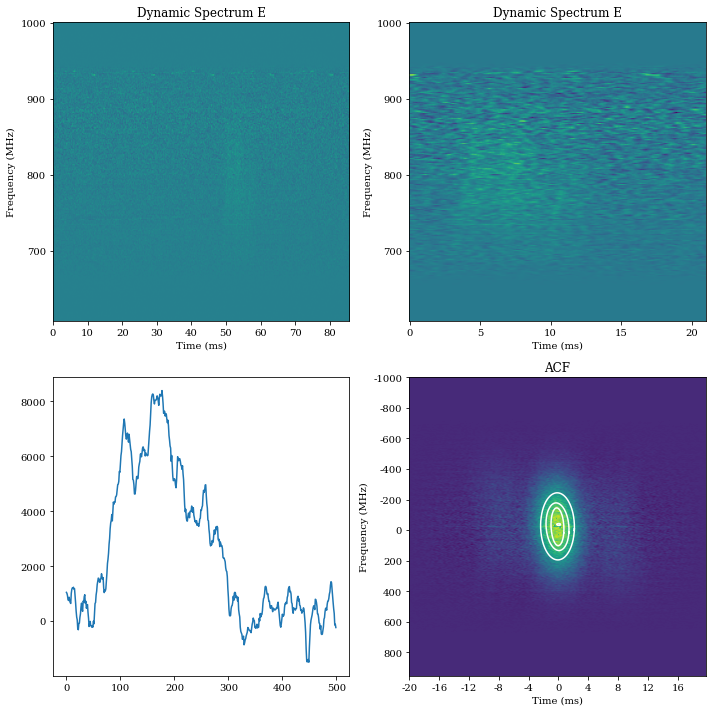

In [37]:
fig = plt.figure(figsize = (10, 10))

sav_c = sav[:, 1100:1600]

ax1 = fig.add_subplot(221)
plt.imshow(sub, interpolation = None, aspect = 'auto')
plt.yticks(np.arange(0, sub.shape[0], 61), [1000, 900, 800, 700, 600])
plt.xticks(np.arange(0, sub.shape[1], 239), [0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum E')


ax2 = fig.add_subplot(222)
plt.imshow(sav_c, aspect = 'auto')
plt.yticks(np.arange(0, sav_c.shape[0], 61), [1000, 900, 800, 700, 600])
plt.xticks(np.arange(0, sav_c.shape[1], 119), [0, 5, 10, 15, 20])
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum E')
#x1 = np.linspace(0, 100 , 100)
#def y(x):
#    return (0.85) * x + 37
#y1 = y(x1)
##print(y1)
#plt.plot(x1, y1, c = 'w')
#print(np.max(isolist.pa))

ax3 = fig.add_subplot(223)
plt.plot(sav_c.sum(0))

ax4 = fig.add_subplot(224)
plt.imshow(acf, aspect = 'auto')
plt.yticks(np.arange(0, acf.shape[0], 49), np.arange(-1000, 1000, 200))
plt.xticks(np.arange(0, acf.shape[1], 181), np.arange(-20, 20, 4))
smas = np.linspace(10, 100, 4)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('ACF')
print(np.tan(np.max(isolist.pa)))



plt.tight_layout()
plt.show()
fig.savefig('D_fourplot.png')